In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003

In [3]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


Crimes have been catogarized in 14 different types.

In [4]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    
    crimes[clss]=num

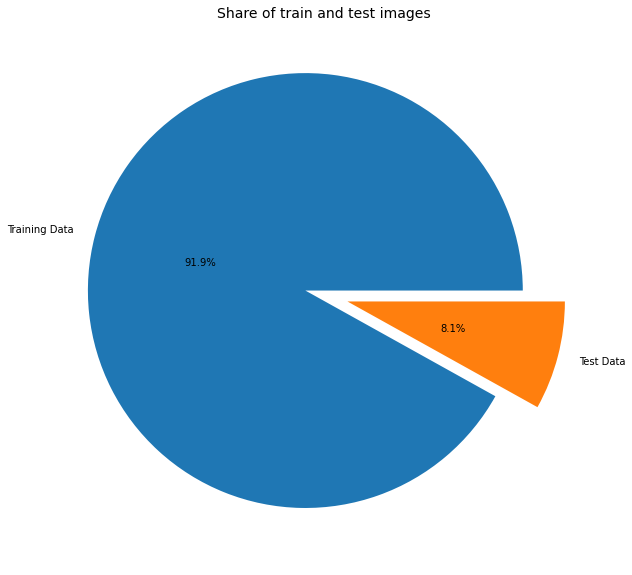

In [5]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

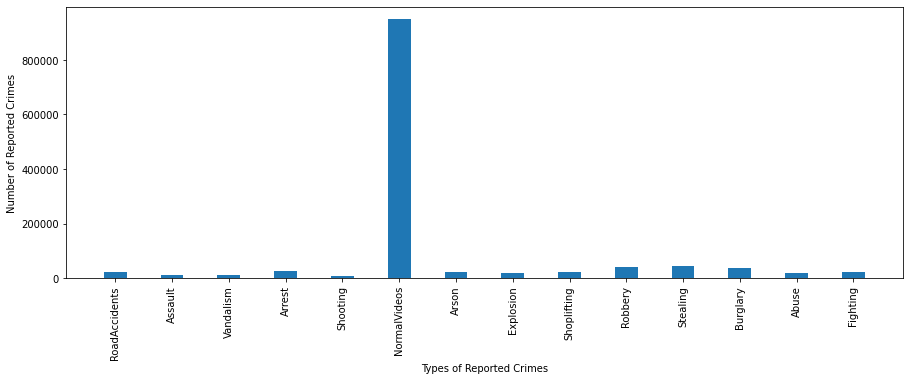

In [6]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4,align="center" )
plt.xticks(rotation=90)

plt.xlabel("Types of Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

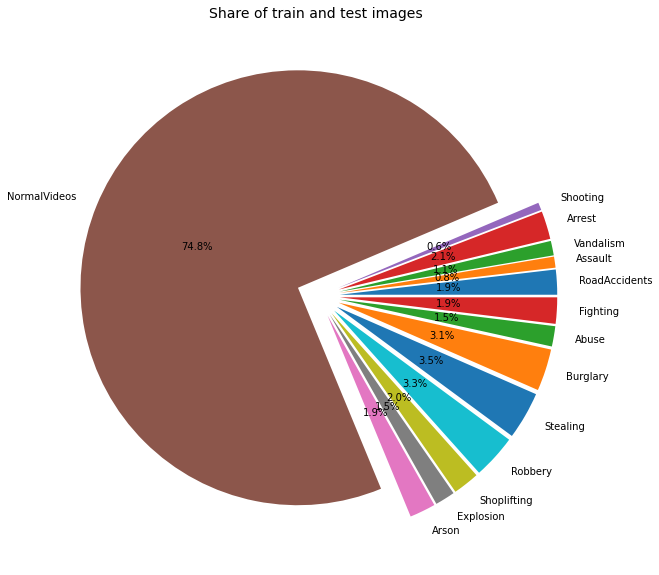

In [7]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [8]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [9]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


2022-01-10 17:23:02.203850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:23:02.204962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:23:02.205600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:23:02.208281: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [10]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    
    for layers in base_model.layers[thr:]:
        layers.trainable=True
    
    return base_model

In [11]:
def create_model():
    model=Sequential()
    
    base_model=transfer_learning()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation="relu"))
    
    model.add(Dense(n,activation="softmax",name="classification"))
    
    model.summary()
    
    return model
    

In [12]:
model=create_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________

In [13]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

2022-01-10 17:36:14.524014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-10 17:36:19.142661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15830/15830 [==============================] - 3537s 222ms/step - loss: 0.0996 - auc: 0.9984 - val_loss: 0.0273 - val_auc: 0.9996


In [14]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [15]:
y_pred=model.predict(test_set)

In [16]:
y_pred

array([[1.58799943e-02, 7.02614263e-02, 8.50219876e-02, ...,
        7.68862665e-03, 4.19790372e-02, 1.04820549e-01],
       [1.62875596e-02, 4.58200574e-02, 5.49110472e-02, ...,
        8.57538916e-03, 7.46833086e-02, 3.37187834e-02],
       [2.53268313e-02, 1.31134585e-01, 2.13461928e-02, ...,
        7.01017957e-03, 3.62854488e-02, 1.42233865e-02],
       ...,
       [2.59542085e-05, 1.31836889e-04, 6.76841883e-05, ...,
        1.99585847e-05, 7.60910734e-06, 7.79415132e-06],
       [1.65604288e-05, 1.38906398e-04, 9.83341015e-05, ...,
        3.14596073e-05, 3.35617119e-06, 4.36257778e-06],
       [5.41013560e-06, 5.77376268e-05, 2.04718835e-05, ...,
        2.22593681e-05, 3.27307794e-06, 1.49002517e-06]], dtype=float32)

In [17]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [18]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8298142844970892


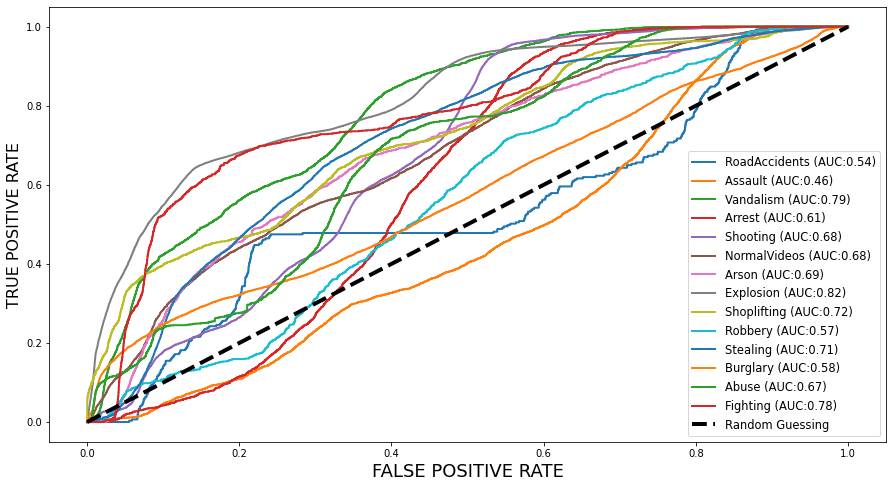

In [19]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()